In [40]:
import ROOT
ROOT.gStyle.SetPalette(61)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
ROOT.gStyle.SetTextFont(42)
ROOT.gStyle.SetTextSize(0.05)
ROOT.gStyle.SetPadTickY(1)

import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

sys.path.append("/eos/home-y/yabulait/wjets/")
sys.path.append("/eos/home-y/yabulait/wjets/time-odd-asymmetry")
from context import (Luminosity_fb, Luminosity_pb, grid_date, leptons,mc_processes, samples)
import pyrootUtil
import json
from wjetsAsymmetryFrame import *

import pyrootUtil.plotUtil.styles as styles

def get_rdf(filePath,branches=["weight_mc", "deta_lj", "Xperp","nbjet", "mT", "qT", "met", "signalMu_pt", "signalMu_charge"]):
    wjets = wjetsAsymmetryFrame()
    try:
        df_preSelected = wjets.load_raw_data(tree_name="nominal", files=[filePath], branches=branches)
    except Exception as inst:
        return None, None
    else:
        dsid = filePath.split('/')[-1]
        dsid = dsid.split('.')[0]
        return  df_preSelected, dsid



def fill_histogram(RDFs, hist, var, weightBR="weight_mc"):
    histoDic = {}
    for dsid, _df in RDFs.items():
            histoDic[dsid] = _df.Histo1D(hist, var, weightBR)
    return histoDic

    
def NormalizeHist(histDic, weightsDic):
    for _id in histDic.keys():
        _weight = Luminosity_pb*weightsDic[_id][1]/weightsDic[_id][0]
        histDic[_id].Scale(_weight)
    return histDic

def groupBy(histDic, processes):
    #processes--> {"wjets": [ids]}
    _hDic={}
    keys = histDic.keys()
    for process, ids in processes.items():
        print ("process, ids = ", process, ids)
        _hist = None
        for _id in keys:
            if _id not in ids: continue
            if _hist is None:
                _hist = histDic[_id].Clone()
            else:
                _hist.Add(histDic[_id].Clone())
        
        _hDic[process] = _hist
    return _hDic

def draw_atlas_label(x=0.57, y=0.85, label="Internal"):
    AL = ROOT.TLatex() #l.SetTextAlign(12) l.SetTextSize(tsize)
    AL.SetNDC()
    AL.SetTextFont(72)
    AL.SetTextColor(ROOT.kBlack)
    Inetrnal = ROOT.TLatex()
    Inetrnal.SetNDC()
    Inetrnal.SetTextFont(42)
    Inetrnal.SetTextColor(ROOT.kBlack)
    ## print text
    TL = ROOT.TLatex()
    TL.SetNDC(1)
    AL.DrawLatex(x,y,"ATLAS")
    Inetrnal.DrawLatex(x+0.12,y,label)
    styles.energy_lumi(x,y-0.06,13, Luminosity_fb)

def createColorTable(size=1, color_map=61):
    ROOT.gStyle.SetPalette(color_map)
    _step = int(color_map/size)   
    return [ROOT.TColor.GetColorPalette(i*_step) for i in range(0,size)]

sample_colors = createColorTable(size=3, color_map=61)
cwjets, cttbar, cWWlpqq = 0,1,2

def plot_samples(hVarDic, log=None, x_label=None, y_label=None):
    if x_label:
        hVarDic["wjets"].GetXaxis().SetTitle(x_label)
    if y_label:
        hVarDic["wjets"].GetYaxis().SetTitle(y_label)
        
    hLabels = list(hVarDic.keys())
    hLists = [hVarDic[key] for key in hLabels]
    canv = fig.plot(hLists,
                hLabels, option="same e0",
                color=sample_colors)
    fig.legend(x=[0.65,0.89], y=[0.73,0.89])
    if log: fig.log(log)
    canv.Draw()


def plot_samples_stack(hVarDic, log=None, x_label=None, y_label=None, Draw_option="HIST SAME PFC PLC"):
    if x_label:
        hVarDic["Wmune"].GetXaxis().SetTitle(x_label)
    if y_label:
        hVarDic["Wmune"].GetYaxis().SetTitle(y_label)
        
    hLabels = list(hVarDic.keys())
    hLists = [hVarDic[key] for key in hLabels]
    canv = fig.stack(hLists, hLabels,
                color=createColorTable(size=len(hLabels), color_map=61), option=Draw_option)
    
    fig.legend(x=[0.65,0.89], y=[0.73,0.89])
    if log: fig.log(log)
    canv.Draw()
    canv.RedrawAxis()
    return canv

In [34]:
event_weights = None
with open("../data/{}/sample_weights.txt".format(grid_date),"r") as f:
    event_weights= json.load( f)
    
process_groups = {"Wenu": ["364170",  "364172",  "364174",  "364176",  "364178",  "364180",
                            "364182",  "364171",  "364173",  "364175",  "364177",  "364179",
                            "364181",  "364183"],
                  "Wmunu" : ["364156", "364157", "364158", "364159", "364160", "364161",
                            "364162", "364163", "364164", "364165", "364166", "364167",
                            "364168", "364169"],
                  "Wtaunu": ["364184", "364185", "364186", "364187", "364188", "364189", "364190",
                            "364191", "364192", "364193", "364194", "364195", "364196", "364197"],
                  "ttbar": ["410470"],
                  "WWlpqq": ["363360", "363361"],
                  "singleTop": ["410646", "410647", "410658", "410659"],
                  "Ztautau": ["364128", "364129", "364130", "364131","364132", "364133",
                             "364134", "364135", "364136", "364137", "364138", "364139",
                             "364140", "364141"],
                  "Zmumu": ["364100", "364101", "364102", "364103", "364104", "364105",
                           "364106", "364107", "364108", "364109", "364110", "364111",
                           "364112", "364113"]
                 }

datatype="mc16"
datasetsRDF_mc16={}

input_dir = "/eos/home-y/yabulait/wjets/ntuples/{0}/{1}/tight_selection/mu/".format(datatype,grid_date)
for dataset in [input_dir+f for f in os.listdir(input_dir)]:
    _df, _dsid = get_rdf(dataset)
    if _df is None: continue
    try:
        _df = _df.Filter("signalMu_charge[0]>0&&signalMu_pt[0]>30000&&(nbjet<1)&&met>30000")
    except:
        print("empty file: ", _dsid)
    else:
        datasetsRDF_mc16[_dsid]= _df



empty file:  364170
empty file:  364179


Error in <TChain::LoadTree>: Cannot find tree with name nominal in file /eos/home-y/yabulait/wjets/ntuples/mc16/20200624_1530/tight_selection/mu/364170.root
Error in <TChain::LoadTree>: Cannot find tree with name nominal in file /eos/home-y/yabulait/wjets/ntuples/mc16/20200624_1530/tight_selection/mu/364179.root


In [37]:

h_qT = fill_histogram(datasetsRDF_mc16,("qT", "qT",20, 0,200000), "qT")
h_mT = fill_histogram(datasetsRDF_mc16,("mT", "mT",20, 0,200000), "mT")
h_deta_lj = fill_histogram(datasetsRDF_mc16,("deta_lj", "deta_lj",40, -5,5), "deta_lj")

h_qT_grouped_by_processes = groupBy(NormalizeHist(h_qT,event_weights), process_groups)
h_mT_grouped_by_processes = groupBy(NormalizeHist(h_mT,event_weights), process_groups)
h_deta_lj_grouped_by_processes = groupBy(NormalizeHist(h_deta_lj,event_weights), process_groups)

process, ids =  wenu ['364170', '364172', '364174', '364176', '364178', '364180', '364182', '364171', '364173', '364175', '364177', '364179', '364181', '364183']
process, ids =  Wmune ['364156', '364157', '364158', '364159', '364160', '364161', '364162', '364163', '364164', '364165', '364166', '364167', '364168', '364169']
process, ids =  Wtaunu ['364184', '364185', '364186', '364187', '364188', '364189', '364190', '364191', '364192', '364193', '364194', '364195', '364196', '364197']
process, ids =  ttbar ['410470']
process, ids =  WWlpqq ['363360', '363361']
process, ids =  singleTop ['410646', '410647', '410658', '410659']
process, ids =  Ztautau ['364128', '364129', '364130', '364131', '364132', '364133', '364134', '364135', '364136', '364137', '364138', '364139', '364140', '364141']
process, ids =  Zmumu ['364100', '364101', '364102', '364103', '364104', '364105', '364106', '364107', '364108', '364109', '364110', '364111', '364112', '364113']
process, ids =  wenu ['364170', '364172

# qT and mT distributions   

* one lepton pT > 30, |eta| < 2.5     
* leading jet pT > 30, |eta| < 4.4     

## qT distribution

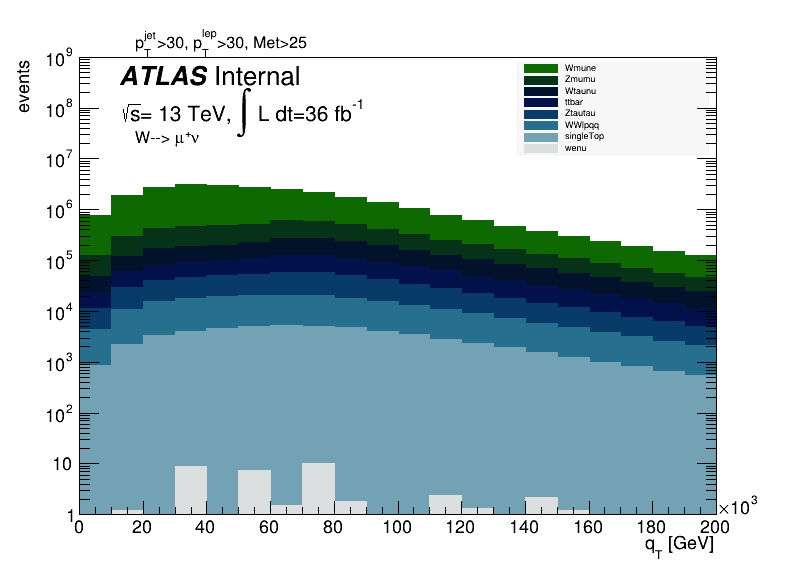

In [43]:


save_dir = "/eos/home-y/yabulait/wjets/plots/pdf/{0}/{1}/tight_selection/mu_plus/".format(datatype,grid_date)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
            
fig = pyrootUtil.histplot("qT",size=[800, 600])
canv_qt = plot_samples_stack(h_qT_grouped_by_processes, log='y', x_label="q_{T} [GeV]", y_label="events")
canv_qt.cd()
draw_atlas_label(x=0.15, y=0.85)
styles.myText(0.17, 0.75, ROOT.kBlack, "W--> #mu^{+}#nu",tsize=0.03)
styles.myText(0.17, 0.915, ROOT.kBlack, "p_{T}^{jet}>30, p_{T}^{lep}>30, Met>25",tsize=0.03)
canv_qt.Print("%s/qT_tight_selection.pdf"%(save_dir))

## mT distribution

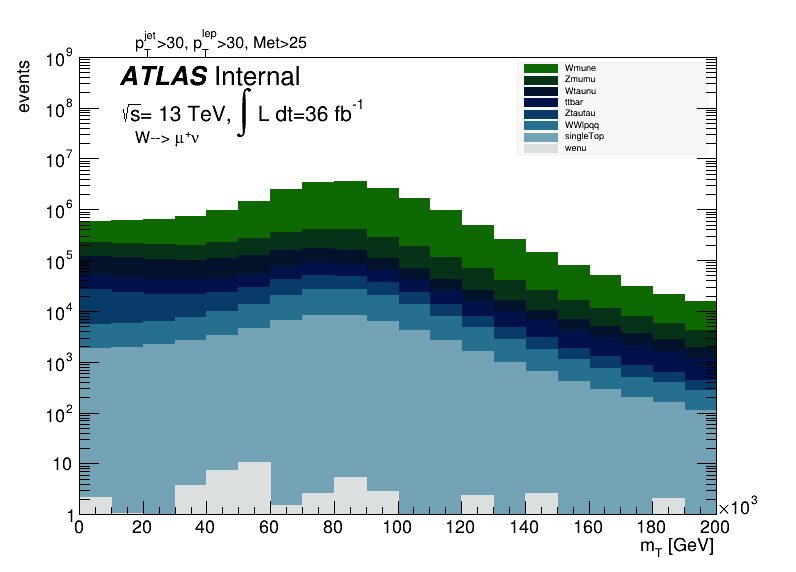

In [45]:
fig = pyrootUtil.histplot("mT",size=[800, 600])
canv_mt=plot_samples_stack(h_mT_grouped_by_processes, log='y', x_label="m_{T} [GeV]", y_label="events")
canv_mt.cd()
draw_atlas_label(x=0.15, y=0.85)
styles.myText(0.17, 0.75, ROOT.kBlack, "W--> #mu^{+}#nu",tsize=0.03)
styles.myText(0.17, 0.915, ROOT.kBlack, "p_{T}^{jet}>30, p_{T}^{lep}>30, Met>25",tsize=0.03)
canv_mt.Print("%s/mT_tight_selection.pdf"%(save_dir))

## h_deta_lj 

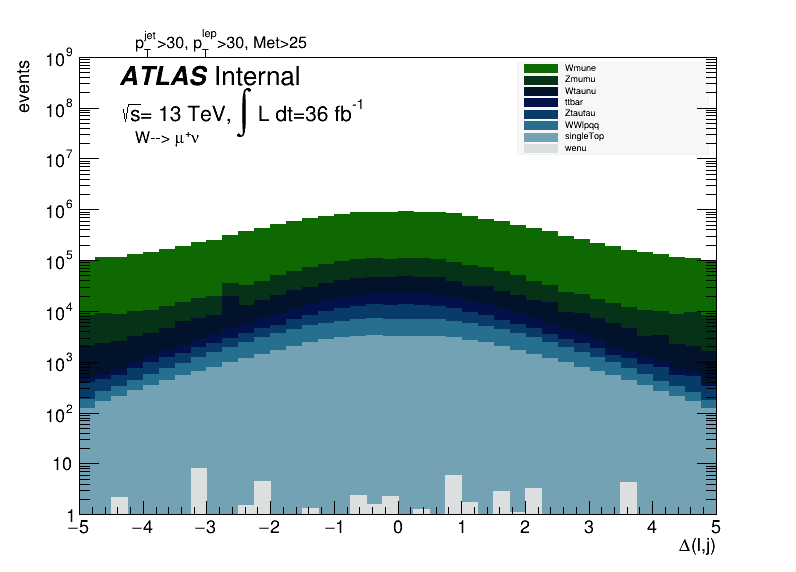

In [46]:
fig = pyrootUtil.histplot("deta_lj",size=[800, 600])
canv_deta_lj = plot_samples_stack(h_deta_lj_grouped_by_processes, log='y', x_label="#Delta(l,j)", y_label="events")
canv_deta_lj.cd()
draw_atlas_label(x=0.15, y=0.85)
styles.myText(0.17, 0.75, ROOT.kBlack, "W--> #mu^{+}#nu",tsize=0.03)
styles.myText(0.17, 0.915, ROOT.kBlack, "p_{T}^{jet}>30, p_{T}^{lep}>30, Met>25",tsize=0.03)
canv_deta_lj.Print("%s/deta_lj_tight_selection.pdf"%(save_dir))

# Signal regions 

* mT > 50 GeV
* qT > 30 GeV
* b-veto (reduce ttbar)

In [ ]:
save_dir = "/eos/home-y/yabulait/wjets/plots/pdf/SR/{}/".format(grid_date)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
datasetsRDF_SR={}
for mc_process in mc_processes:
    _lepton ="el_plus"
    input_dir = "/eos/home-y/yabulait/wjets/ntuples/preselected/{0}/{1}/{2}/".format(mc_process, grid_date,_lepton)
    for dataset in [input_dir+f for f in os.listdir(input_dir)]:
        _df, _dsid = get_rdf(dataset)
        datasetsRDF_SR[_dsid]=_df.Filter("(nbjet<1)&&mT>50&&qT>30&&abs(Xprep)>0.6")
        
h_qT_SR = fill_histogram(datasetsRDF_SR,("qT", "qT",20, 0,200), "qT")
h_mT_SR = fill_histogram(datasetsRDF_SR,("mT", "mT",20, 0,200), "mT")
h_deta_lj_SR = fill_histogram(datasetsRDF_SR,("deta_lj", "deta_lj",40, -5,5), "deta_lj")

h_qT_SR_grouped_by_processes = groupBy(NormalizeHist(h_qT_SR,event_weights), process_groups)
h_mT_SR_grouped_by_processes = groupBy(NormalizeHist(h_mT_SR,event_weights), process_groups)
h_deta_lj_SR_grouped_by_processes = groupBy(NormalizeHist(h_deta_lj_SR,event_weights), process_groups)


## qT distribution
* mT > 50 GeV

In [ ]:
fig = pyrootUtil.histplot("qT",size=[800, 600])
canv_qT = plot_samples_stack(h_qT_SR_grouped_by_processes, log='y', x_label="q_{T} [GeV]", y_label="events")
canv_qT.cd()
draw_atlas_label(x=0.15, y=0.85)
styles.myText(0.17, 0.75, ROOT.kBlack, "W--> e^{+}#nu",tsize=0.03)
styles.myText(0.17, 0.915, ROOT.kBlack, 
              "p_{T}^{jet}>30, p_{T}^{lep}>30, Met>25,m_{T}>50, q_{T}>30, b-veto, |#Chi_{#perp}|>0.6",tsize=0.03)
canv_qT.Print("%s/qT_SR_%s.pdf"%(save_dir,lepton))

## mT distribution
* mT > 50 GeV

In [ ]:
fig = pyrootUtil.histplot("mT",size=[800, 600])
canv_mT = plot_samples_stack(h_mT_SR_grouped_by_processes, log='y', x_label="m_{T} [GeV]", y_label="events")
canv_mT.cd()
draw_atlas_label(x=0.15, y=0.85)
styles.myText(0.17, 0.75, ROOT.kBlack, "W--> e^{+}#nu",tsize=0.03)
styles.myText(0.17, 0.915, ROOT.kBlack,
              "p_{T}^{jet}>30, p_{T}^{lep}>30, Met>25,m_{T}>50, q_{T}>30, b-veto, |#Chi_{#perp}|>0.6",
              tsize=0.03)
canv_mT.Print("%s/mT_SR_%s.pdf"%(save_dir,lepton))

# delta_lj

In [ ]:
fig = pyrootUtil.histplot("deta_lj",size=[800, 600])
canv_deta_lj = plot_samples_stack(h_deta_lj_SR_grouped_by_processes, log='y', x_label="#Delta(l,j)", y_label="events")
canv_deta_lj.cd()
draw_atlas_label(x=0.15, y=0.85)
styles.myText(0.17, 0.75, ROOT.kBlack, "W--> e^{+}#nu",tsize=0.03)
styles.myText(0.17, 0.915, ROOT.kBlack,
              "p_{T}^{jet}>30, p_{T}^{lep}>30, Met>25,m_{T}>50, q_{T}>30, b-veto, |#Chi_{#perp}|>0.6",
              tsize=0.03)
canv_deta_lj.Print("%s/deta_lj_SR_%s.pdf"%(save_dir,lepton))

# Asymmetry



In [ ]:
datasetsRDF_Xprep_positive={}
datasetsRDF_Xprep_negetive={}
datasetsRDF_Xprep={}
for mc_process in mc_processes:
    _lepton ="el_plus"
    input_dir = "/eos/home-y/yabulait/wjets/ntuples/preselected/{0}/{1}/{2}/".format(mc_process, grid_date,_lepton)
    for dataset in [input_dir+f for f in os.listdir(input_dir)]:
        _df, _dsid = get_rdf(dataset)
        _df_sr=_df.Filter("(nbjet<1)&&mT>50&&qT>30")
        if "wjets" in mc_process:  _df_sr = _df_sr.Filter('abs(mcEventWeight)<100')
        datasetsRDF_Xprep[_dsid] = _df_sr.Filter("deta_lj >1.0")
        datasetsRDF_Xprep_positive[_dsid] = _df_sr.Filter("Xprep > 0.6")
        datasetsRDF_Xprep_negetive[_dsid] = _df_sr.Filter("Xprep < -0.6")
        

hXprep_SR = fill_histogram(datasetsRDF_Xprep,("Xprep","Xprep",100,-3.5,3.5), "Xprep")
hp_deta_SR = fill_histogram(datasetsRDF_Xprep_positive,("hEtaPlus","hEtaPlus",16,-4,4), "deta_lj")
hn_deta_SR = fill_histogram(datasetsRDF_Xprep_negetive,("hEtaMinus","hEtaMinus",16,-4,4), "deta_lj")

hp_deta_SR_grouped_by_processes = groupBy(NormalizeHist(hp_deta_SR,event_weights), process_groups)
hn_deta_SR_grouped_by_processes = groupBy(NormalizeHist(hn_deta_SR,event_weights), process_groups)
hXprep_SR_grouped_by_processes = groupBy(NormalizeHist(hXprep_SR,event_weights), process_groups)

def asymmetry(hpDic, hnDic):
    _hAsymDic = {}
    for key in hpDic.keys():
        h_total = hpDic[key].Clone()
        h_total.Add(hnDic[key].Clone())
        h_asymmetry =hpDic[key].Clone()
        h_asymmetry.Add(hnDic[key].Clone(), -1.0)
        h_asymmetry.Divide(h_total)
        _hAsymDic[key] = h_asymmetry
    return _hAsymDic

In [ ]:
hAsym_samples = asymmetry(hp_deta_SR_grouped_by_processes, hn_deta_SR_grouped_by_processes)

In [ ]:
save_dir = "/eos/home-y/yabulait/wjets/plots/pdf/SR/{}/".format(grid_date)
def plot_asymmetry(hSample, label=""):
    hSample.GetXaxis().SetTitle("#Delta(l,j)")
    hSample.GetYaxis().SetTitle("Asymmetry")
    hSample.SetMarkerStyle(20)
    canv = fig.plot([hSample], [label], option="hist e0",
                color=[ ROOT.kBlack])
    #fig.legend(x=[0.65,0.89], y=[0.73,0.89])
    fig.grid('xy')
    canv.Draw()
    return canv

In [ ]:
fig = pyrootUtil.histplot("Asymmetry",size=[800, 600])

canv_asym = plot_asymmetry(hAsym_samples["wjets"], "wjets")

canv_asym.cd()
draw_atlas_label(x=0.15, y=0.85)
styles.myText(0.17, 0.75, ROOT.kBlack, "W--> e^{+}#nu",tsize=0.03)
styles.myText(0.17, 0.915, ROOT.kBlack,
              "p_{T}^{jet}>30, p_{T}^{lep}>30, Met>25,m_{T}>50, q_{T}>30, b-veto, |#Chi_{#perp}|>0.6",
              tsize=0.03)
canv_asym.Print("%s/wjets_Asym_%s.pdf"%(save_dir,lepton))

In [ ]:
fig = pyrootUtil.histplot("Asymmetry",size=[800, 600])
hAsym_samples["ttbar"].GetYaxis().SetRangeUser(-0.2,0.2)
canv_asym = plot_asymmetry(hAsym_samples["ttbar"], "ttbar")

canv_asym.cd()
draw_atlas_label(x=0.15, y=0.85)
styles.myText(0.17, 0.75, ROOT.kBlack, "t#bar{t}--> e^{+}#nu qq",tsize=0.03)
styles.myText(0.17, 0.915, ROOT.kBlack, 
              "p_{T}^{jet}>30, p_{T}^{lep}>30, Met>25,m_{T}>50, q_{T}>30, b-veto, |#Chi_{#perp}|>0.6",
              tsize=0.03)
canv_asym.Print("%s/ttbar_Asym_%s.pdf"%(save_dir,lepton))

In [ ]:
fig = pyrootUtil.histplot("Asymmetry",size=[800, 600])
hAsym_samples["singleTop"].GetYaxis().SetRangeUser(-0.2,0.2)
canv_asym = plot_asymmetry(hAsym_samples["singleTop"], "singleTop")

canv_asym.cd()
draw_atlas_label(x=0.15, y=0.85)
styles.myText(0.17, 0.75, ROOT.kBlack, "wt--> e^{+}#nu qq",tsize=0.03)
styles.myText(0.17, 0.915, ROOT.kBlack, 
              "p_{T}^{jet}>30, p_{T}^{lep}>30, Met>25,m_{T}>50, q_{T}>30, b-veto, |#Chi_{#perp}|>0.6",
              tsize=0.03)
canv_asym.Print("%s/signelTop_Asym_%s.pdf"%(save_dir,lepton))

In [ ]:
fig = pyrootUtil.histplot("Asymmetry",size=[800, 600])

canv_asym = plot_asymmetry(hAsym_samples["WWlpqq"], "WWlpqq")

canv_asym.cd()
draw_atlas_label(x=0.15, y=0.85)
styles.myText(0.17, 0.75, ROOT.kBlack, "W--> e^{+}#nu, W--> qq",tsize=0.03)
styles.myText(0.17, 0.915, ROOT.kBlack, 
              "p_{T}^{jet}>30, p_{T}^{lep}>30, Met>25,m_{T}>50, q_{T}>30, b-veto, |#Chi_{#perp}|>0.6",
              tsize=0.03)
canv_asym.Print("%s/WWlpqq_Asym_%s.pdf"%(save_dir,lepton))

In [ ]:
def plop_xprep(hSample, label=""):
    hSample.GetXaxis().SetTitle("#Chi_{#perp}")
    hSample.GetYaxis().SetTitle("event")
    hSample.SetMarkerStyle(20)
    canv = fig.plot([hSample], [label], option="hist eo",
                color=[ ROOT.kBlack])
    #fig.legend(x=[0.65,0.89], y=[0.73,0.89])
    fig.grid('xy')
    canv.Draw()
    return canv

In [ ]:
fig = pyrootUtil.histplot("Xprep",size=[800, 600])
hXprep_SR_grouped_by_processes["wjets"].SetMaximum(hXprep_SR_grouped_by_processes["wjets"].GetMaximum()*1.2)
canv_xperp = plop_xprep(hXprep_SR_grouped_by_processes["wjets"],
                        label="wjets")
canv_xperp.cd()
draw_atlas_label(x=0.15, y=0.85)
styles.myText(0.17, 0.75, ROOT.kBlack, "W--> e^{+}",tsize=0.03)
styles.myText(0.17, 0.915, ROOT.kBlack,
              "p_{T}^{jet}>30, p_{T}^{lep}>30, Met>25,m_{T}>50, q_{T}>30, b-veto",
              tsize=0.03)
canv_xperp.Print("%s/wjets_xperp_%s.pdf"%(save_dir,lepton))

In [ ]:
fig = pyrootUtil.histplot("Xprep",size=[800, 600])
hXprep_SR_grouped_by_processes["ttbar"].SetMaximum(hXprep_SR_grouped_by_processes["ttbar"].GetMaximum()*1.2)
canv_xperp = plop_xprep(hXprep_SR_grouped_by_processes["ttbar"], label="ttbar")

canv_xperp.cd()
draw_atlas_label(x=0.15, y=0.85)
styles.myText(0.17, 0.75, ROOT.kBlack, "t#bar{t}--> e^{+}#nu qq",tsize=0.03)
styles.myText(0.17, 0.915, ROOT.kBlack,
              "p_{T}^{jet}>30, p_{T}^{lep}>30, Met>25,m_{T}>50, q_{T}>30, b-veto",
              tsize=0.03)
canv_xperp.Print("%s/ttbar_xperp_%s.pdf"%(save_dir,lepton))

In [ ]:
fig = pyrootUtil.histplot("Xprep",size=[800, 600])
hXprep_SR_grouped_by_processes["singleTop"].SetMaximum(hXprep_SR_grouped_by_processes["singleTop"].GetMaximum()*1.2)
canv_xperp = plop_xprep(hXprep_SR_grouped_by_processes["singleTop"], label="singleTop")

canv_xperp.cd()
draw_atlas_label(x=0.15, y=0.85)
styles.myText(0.17, 0.75, ROOT.kBlack, "wt--> e^{+}#nu qq",tsize=0.03)
styles.myText(0.17, 0.915, ROOT.kBlack,
              "p_{T}^{jet}>30, p_{T}^{lep}>30, Met>25,m_{T}>50, q_{T}>30, b-veto",
              tsize=0.03)
canv_xperp.Print("%s/singleTop_xperp_%s.pdf"%(save_dir,lepton))

In [ ]:
fig = pyrootUtil.histplot("Xprep",size=[800, 600])
hXprep_SR_grouped_by_processes["WWlpqq"].SetMaximum(hXprep_SR_grouped_by_processes["WWlpqq"].GetMaximum()*1.2)
canv_xperp = plop_xprep(hXprep_SR_grouped_by_processes["WWlpqq"], label="WWlpqq")

canv_xperp.cd()
draw_atlas_label(x=0.15, y=0.85)
styles.myText(0.17, 0.75, ROOT.kBlack, "W--> e^{+}#nu, W--> qq",tsize=0.03)
styles.myText(0.17, 0.915, ROOT.kBlack,
              "p_{T}^{jet}>30, p_{T}^{lep}>30, Met>25,m_{T}>50, q_{T}>30, b-veto",
              tsize=0.03)
canv_xperp.Print("%s/WWlpqq_xperp_%s.pdf"%(save_dir,lepton))

In [ ]:
#styles.ATLAS_style(ROOT.gStyle)
fig = pyrootUtil.histplot("Xprep",size=[800, 600])
canv_xperp = plot_samples_stack(hXprep_SR_grouped_by_processes, log='y', x_label="#Chi_{#perp}", y_label="events",
                                Draw_option="HIST SAME PFC PLC PMC Y-")
canv_xperp.cd()
draw_atlas_label(x=0.15, y=0.85)
styles.myText(0.17, 0.75, ROOT.kBlack, "W--> e^{+}",tsize=0.03)
styles.myText(0.17, 0.915, ROOT.kBlack,
              "p_{T}^{jet}>30, p_{T}^{lep}>30, Met>25,m_{T}>50, q_{T}>30, b-veto",
              tsize=0.03)
canv_xperp.Print("%s/stack_xperp_%s.pdf"%(save_dir,lepton))
